##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Build a linear model with Estimators

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/estimator/linear"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/estimator/linear.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

> Warning: Estimators are not recommended for new code.  Estimators run `v1.Session`-style code which is more difficult to write correctly, and can behave unexpectedly, especially when combined with TF 2 code. Estimators do fall under our [compatibility guarantees](https://tensorflow.org/guide/versions), but will receive no fixes other than security vulnerabilities. See the [migration guide](https://tensorflow.org/guide/migrate) for details.

## Overview

This end-to-end walkthrough trains a logistic regression model using the `tf.estimator` API. The model is often used as a baseline for other, more complex, algorithms.

Note: A Keras logistic regression example is [available](https://tensorflow.org/guide/migrate/tutorials/keras/regression) and is recommended over this tutorial.


## Setup

In [2]:
import pandas as pd
from IPython.display import clear_output

import tensorflow as tf

2023-04-13 17:36:41.033745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the titanic dataset
You will use the Titanic dataset with the (rather morbid) goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [3]:
# Load dataset.
df_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df_eval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = df_train.pop("survived")
y_eval = df_eval.pop("survived")

## Explore the data

The dataset contains the following features

In [4]:
df_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
df_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 examples in the training and evaluation sets, respectively.

In [6]:
df_train.shape[0], df_eval.shape[0]

(627, 264)

The majority of passengers are in their 20's and 30's.

<Axes: >

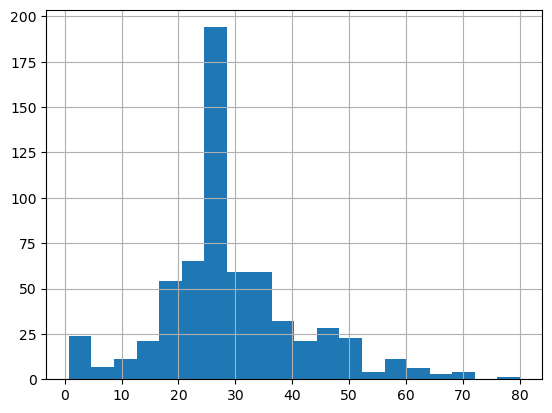

In [7]:
df_train.age.hist(bins=20)

There are approximately twice as many male passengers as female passengers aboard.

<Axes: ylabel='sex'>

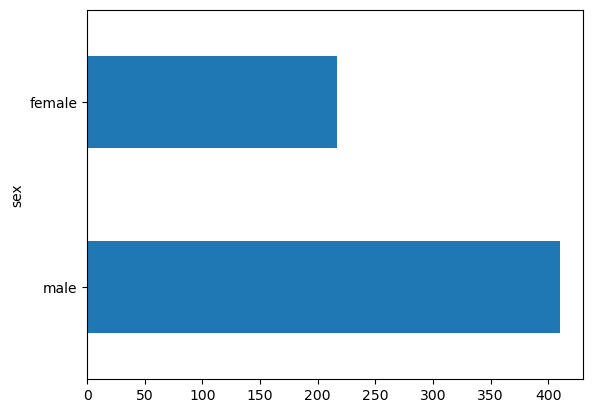

In [8]:
df_train.sex.value_counts().plot(kind="barh")

The majority of passengers were in the "third" class.

<Axes: ylabel='class'>

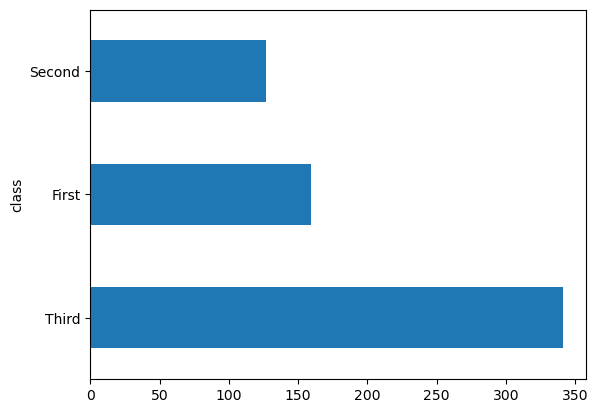

In [9]:
df_train["class"].value_counts().plot(kind="barh")

Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.

Text(0.5, 0, '% survive')

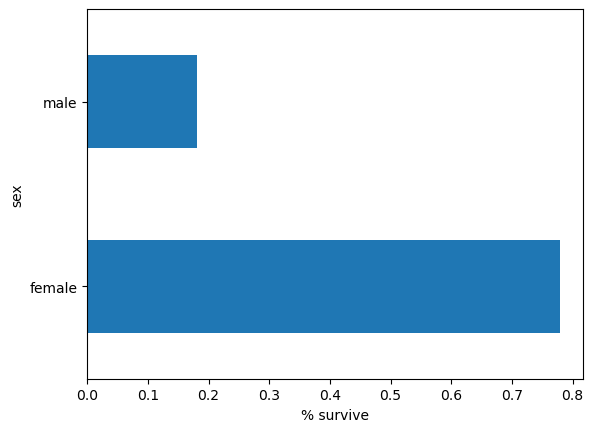

In [10]:
pd.concat([df_train, y_train], axis=1).groupby("sex").survived.mean().plot(kind="barh").set_xlabel("% survive")

## Feature Engineering for the Model

> Warning: The tf.feature_columns module described in this tutorial is not recommended for new code. Keras preprocessing layers cover this functionality, for migration instructions see the [Migrating feature columns guide](https://www.tensorflow.org/guide/migrate/migrating_feature_columns). The tf.feature_columns module was designed for use with TF1 Estimators. It does fall under our [compatibility guarantees](https://tensorflow.org/guide/versions), but will receive no fixes other than security vulnerabilities.

Estimators use a system called [feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns) to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and *feature columns* describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features `dict` (a *base feature column*), or any new columns created using transformations defined over one or multiple base columns (a *derived feature columns*).

The linear estimator uses both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.

### Base Feature Columns

In [11]:
CATEGORICAL_COLUMNS = ["sex", "n_siblings_spouses", "parch", "class", "deck",
                       "embark_town", "alone"]
NUMERIC_COLUMNS = ["age", "fare"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [12]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

### Training Process

So we are done preparing our dataset and I feel as though it's a good time to explain how our model is trained. Specifically how input data is fed to our model.

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We'll actually feed these batches to our model multiple times according to the number of *epochs*.

An *epoch* is simply one stram of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. If we have 10 epochs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times we need to create something called an *input function*. The input function simply defines how our dataset will be converted into batches at each epoch.

The `input_function` specifies how data is converted to a `tf.data.Dataset` that feeds the input pipeline in a streaming fashion. `tf.data.Dataset` can take in multiple sources such as a dataframe, a csv-formatted file, and more.

### Input function

The TensorFlow model we are going to use requires that the data we pass it comes in as a `tf.data.Dataset` object. This means we must create an _input function_ that can convert our current pandas dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight from the [TensorFlow documentation](https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandable, but you want to refer to the documentation for a detailed explanation of each method.

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    """Inner function this will be returned"""
    # Create tf.data.Dataset object with object and its labels
    dset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      # Randomize order of data
      dset = dset.shuffle(1000)
    # Split dataset into batches of 32 and repeat process for number of epochs
    return dset.batch(batch_size).repeat(num_epochs)
  # Return a function object for use
  return input_function

train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn = make_input_fn(df_eval, y_eval, num_epochs=1, shuffle=False)

You can inspect the dataset:

In [14]:
ds = make_input_fn(df_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print("Some feature keys:", list(feature_batch.keys()))
  print()
  print("A batch of class:", feature_batch["class"].numpy())
  print()
  print("A batch of Labels:", label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Third' b'Second' b'Third' b'Third' b'Third' b'Third' b'Third' b'Third'
 b'Third' b'Third']

A batch of Labels: [0 1 0 0 0 1 0 0 1 0]


2023-04-13 17:36:43.557673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:36:43.558645: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


After adding all the base features to the model, let's train the model. Training a model is just a single command using the `tf.estimator` API:

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.83247626, 'auc_precision_recall': 0.7877053, 'average_loss': 0.48124143, 'label/mean': 0.375, 'loss': 0.47245544, 'precision': 0.7241379, 'prediction/mean': 0.34309864, 'recall': 0.6363636, 'global_step': 200}


### Derived Feature Columns

Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. For example, the correlation between age and the label may be different for different gender. Therefore, if you only learn a single model weight for `gender="Male"` and `gender="Female"`, you won't capture every age-gender combination (e.g. distinguishing between `gender="Male"` AND `age="30"` AND `gender="Male"` AND `age="40"`).

To learn the differences between different feature combinations, you can add *crossed feature columns* to the model (you can also bucketize age column before the cross column):

In [16]:
age_x_gender = tf.feature_column.crossed_column(["age", "sex"], hash_bucket_size=100)

After adding the combination feature to the model, let's train the model again:

In [17]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.84582186, 'auc_precision_recall': 0.7670792, 'average_loss': 0.5222097, 'label/mean': 0.375, 'loss': 0.5141704, 'precision': 0.8214286, 'prediction/mean': 0.2582431, 'recall': 0.46464646, 'global_step': 200}


It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. You can try using more features and transformations to see if you can do better!

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier,  the `eval_input_fn` was  defined using the entire evaluation set.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsf1h6tpp/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

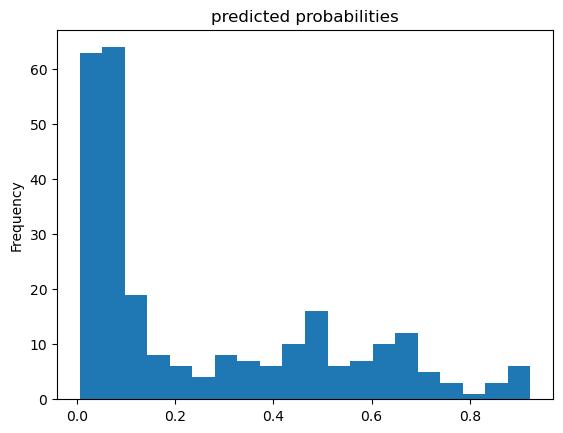

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred["probabilities"][1] for pred in pred_dicts])

probs.plot(kind="hist", bins=20, title="predicted probabilities")

Finally, look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.

(0.0, 1.05)

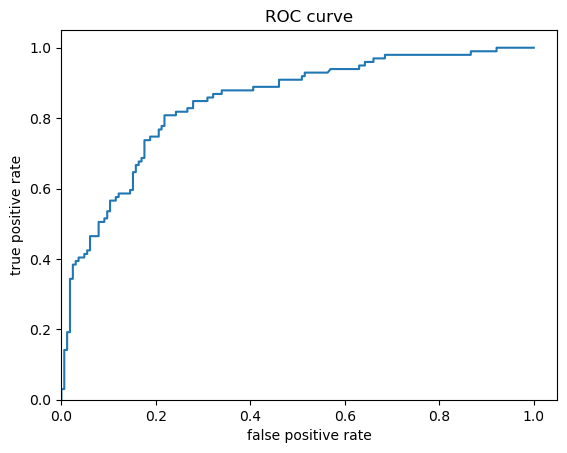

In [19]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xlim(0,)
plt.ylim(0,)